# Building Pipelines with Artifacts

Data science workflows revolve around building and refining pipelines, i.e. series of processes that transform data into useful information/product (read more about pipelines [here](https://docs.lineapy.org/en/latest/fundamentals/concepts.html#pipeline)).

Traditionally, this is often manual and time-consuming work as data scientists (or other engineers) need to clean up messy development code and transform it into deployable scripts for the target system (e.g., Airflow).

Having the complete development process stored in artifacts, LineaPy can automate such code transformation, accelerating transition from development to production. In this tutorial, we will walk through a small example of data science workflow to illustrate how this can be done.

**Table of Contents**

- [Development Sessions](#Development-Sessions)
- [Pipeline Building](#Pipeline-Building)

<div class="alert alert-info">

If you encounter issues you cannot resolve, simply ask in our [Slack community](https://join.slack.com/t/lineacommunity/shared_invite/zt-18kizfn3b-1Qu_HDT3ahGudnAwoFAw9Q)'s `#support` channel. We are always happy and ready to help you!

</div>

<div class="alert alert-info">

You can ignore `# NBVAL_*` comments in certain cell blocks. They are for passing unit tests only, which we do to make sure the examples are always functional as we update the codebase.

</div>

In [1]:
# NBVAL_IGNORE_OUTPUT

import os
import lineapy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

lineapy.options.set("is_demo", True)

## Exploration and Pre-processing

We are a botanist working in an ecology lab, and we recently obtained a data set to explore. Let's see what it contains.

In [2]:
# NBVAL_IGNORE_OUTPUT

# Load data
url = "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv"
df = pd.read_csv(url)

In [3]:
# View data
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


It is simple data that contains different iris species and their physical measurements. Our common sense dictates that petal and sepal traits may have an association. Let's quickly check.

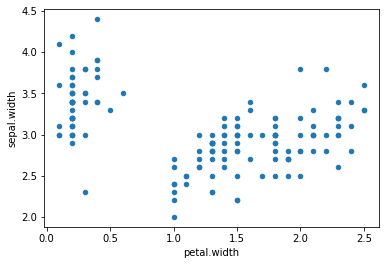

In [4]:
# Plot petal vs. sepal width
df.plot.scatter("petal.width", "sepal.width")
plt.show()

Interestingly, we observe what appears to be an inverse relationship between petal and sepal widths. That is, the wider an iris's petal is, the narrower its sepal is.

Can we quantify this relationship? We can check correlation coefficient:

In [5]:
# Calculate correlation coefficient
df[["petal.width", "sepal.width"]].corr(method="pearson")

,petal.width,sepal.width
petal.width,1.000000,-0.366126
sepal.width,-0.366126,1.000000


The value confirms our visual observation: petal and sepal widths are negatively correlated.

However, we also notice from the scatter plot that it consists of two distinct clusters of observations, one of which shows a positive pattern. Could this be a reflection of different subgroups, i.e., different iris species in our case? Let's plot observations by species.

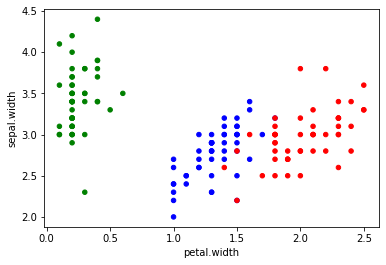

In [6]:
# Map each species to a color
color_map = {"Setosa": "green", "Versicolor": "blue", "Virginica": "red"}
df["variety_color"] = df["variety"].map(color_map)

# Plot petal vs. sepal width by species
df.plot.scatter("petal.width", "sepal.width", c="variety_color")
plt.show()

We indeed visually confirm that the overall negative association is rather a spurious result from the confounding effect of species; within each species, petal and sepal widths seem to be positively correlated.

To make our analysis more interesting, let's try some formal modeling. Given the linear-looking relationship *within each species*, we can use linear regression. Before doing any modeling, however, we need to pre-process the data. Specifically, `variety` needs to be transformed into a set of numeric variables so that the model can use the information. Let's have Setosa as the baseline category.

In [7]:
# Check species and their counts
df["variety"].value_counts()

Setosa        50
Versicolor    50
Virginica     50
Name: variety, dtype: int64

In [8]:
# Create dummy variables encoding species
df["d_versicolor"] = df["variety"].apply(lambda x: 1 if x == "Versicolor" else 0)
df["d_virginica"] = df["variety"].apply(lambda x: 1 if x == "Virginica" else 0)

In [9]:
# View data
df

,sepal.length,sepal.width,petal.length,petal.width,variety,variety_color,d_versicolor,d_virginica
0,5.1,3.5,1.4,0.2,Setosa,green,0,0
1,4.9,3.0,1.4,0.2,Setosa,green,0,0
2,4.7,3.2,1.3,0.2,Setosa,green,0,0
3,4.6,3.1,1.5,0.2,Setosa,green,0,0
4,5.0,3.6,1.4,0.2,Setosa,green,0,0
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica,red,0,1
146,6.3,2.5,5.0,1.9,Virginica,red,0,1
147,6.5,3.0,5.2,2.0,Virginica,red,0,1
148,6.2,3.4,5.4,2.3,Virginica,red,0,1


Let's store the pre-processed data as an artifact since we may want to reuse/recompute it later.

In [10]:
# NBVAL_IGNORE_OUTPUT

# Save side effects as an artifact
lineapy.save(df, "iris_preprocessed")

LineaArtifact(name='iris_preprocessed', _version=0)

## Modeling

Let's now start working on model building with the pre-processed data.

In [11]:
# Initiate the model
mod = LinearRegression()

# Fit the model
mod.fit(
    X=df[["petal.width", "d_versicolor", "d_virginica"]],
    y=df["sepal.width"],
)

LinearRegression()

In [12]:
# NBVAL_IGNORE_OUTPUT

# Check result
print(f"Coefficient for petal.width: {mod.coef_[0]}")
print(f"Coefficient for d_versicolor: {mod.coef_[1]}")
print(f"Coefficient for d_virginica: {mod.coef_[2]}")

Coefficient for petal.width: 0.781015495565735
Coefficient for d_versicolor: -1.5014967352109916
Coefficient for d_virginica: -1.8442075821070065


Consistent with what we observed in the scatter plot, we get a positive coefficient value for petal width. That is, controlling for the iris type, a petal width has a positive association with sepal width. Specifically, the model suggests that a unit increase in pedal width is associated with about 0.8 unit increase in sepal width.

Now, we save the model as an artifact as well since we may want to reuse/recompute it later.

In [13]:
# NBVAL_IGNORE_OUTPUT

# Save the fitted model as an artifact
lineapy.save(mod, "iris_model")

LineaArtifact(name='iris_model', _version=1)

## Pipeline Building

Say we are interested in regularly retraining the model to account for any updates in the source data (`iris.csv`). Now, we need to set up a pipeline to:

1. Pre-process the source (raw) data
2. Train the model with the pre-processed data

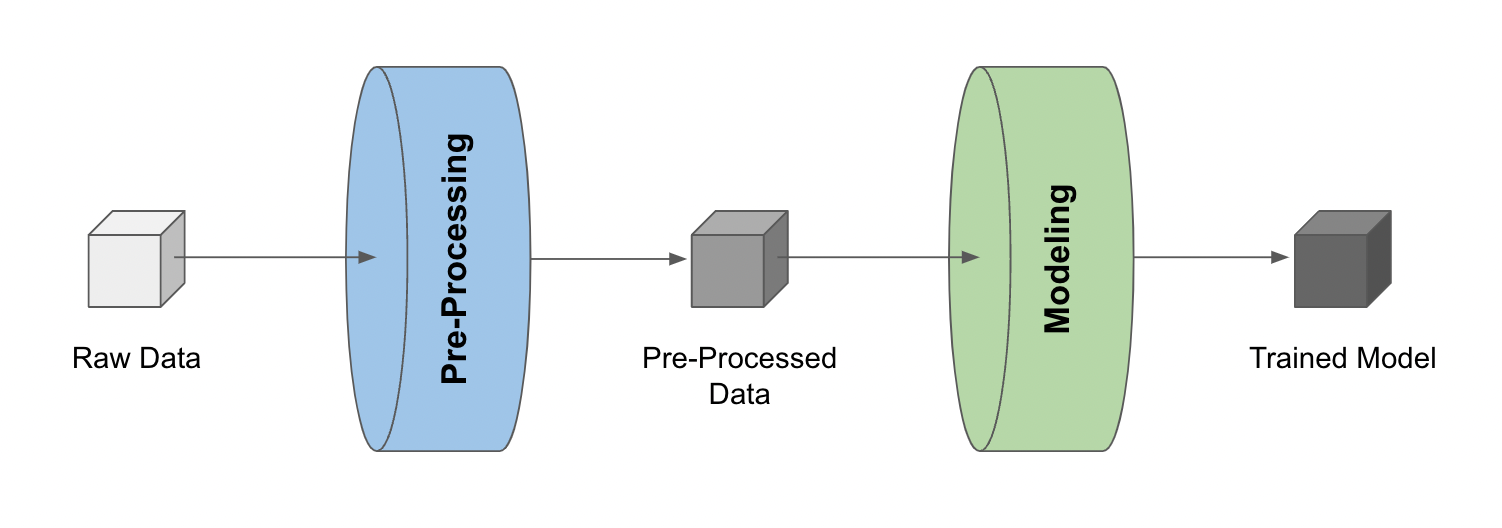

Normally, this would involve finding our old code, cleaning it up, and transforming it into a deployable pipeline &mdash; all manually. Thankfully, we had already captured the relevant development history across LineaPy artifacts, so, for us, building a pipeline reduces to “stitching” these artifacts.

In [14]:
# NBVAL_IGNORE_OUTPUT

# Build an Airflow pipeline using artifacts
lineapy.to_pipeline(
    pipeline_name="iris_pipeline",
    artifacts=["iris_preprocessed", "iris_model"],
    dependencies={"iris_model": {"iris_preprocessed"}},
    output_dir="./output/pipeline_basics/",
    framework="AIRFLOW",
)

Generated module file: output/pipeline_basics/iris_pipeline_module.py                                                                                                                                        
Generated requirements file: output/pipeline_basics/iris_pipeline_requirements.txt                                                                                                                           
Generated DAG file: output/pipeline_basics/iris_pipeline_dag.py                                                                                                                                              
Generated Docker file: output/pipeline_basics/iris_pipeline_Dockerfile                                                                                                                                       


PosixPath('output/pipeline_basics')

where

- `artifacts` is the list of artifact names to be used for the pipeline
- `pipeline_name` is the name of the pipeline
- `dependencies` is the dependency graph among artifacts
    - If artifact A depends on artifacts B and C, then the graph is specified as `{ A: { B, C } }`
    - If A depends on B and B depends on C, then the graph is specified as `{ A: { B }, B: { C } }`
- `output_dir` is the location to put the files for running the pipeline
- `framework` is the name of orchestration framework to use
    - LineaPy currently supports `"AIRFLOW"` and `"SCRIPT"`
    - If `"AIRFLOW"`, it will generate files that can run Airflow DAGs
    - If `"SCRIPT"`, it will generate files that can run the pipeline as a Python script

### Output Files

We see the pipeline building resulting in the following files:

In [15]:
# NBVAL_IGNORE_OUTPUT

# Check the generated files for running the pipeline
os.listdir("./output/pipeline_basics/")

['iris_pipeline_dag.py',
 'iris_pipeline_Dockerfile',
 'iris_pipeline_module.py',
 'iris_pipeline_requirements.txt']

where

- `[PIPELINE-NAME]_module.py` contains the artifact code packaged as a function module
- `[PIPELINE-NAME]_dag.py` uses the packaged function(s) to define the pipeline
- `[PIPELINE-NAME]_requirements.txt` lists any package dependencies for running the pipeline
- `[PIPELINE-NAME]_Dockerfile` contains commands to set up the environment to run the pipeline

Specifically, in the current case, we have `iris_pipeline_module.py` looking as follows:

In [16]:
# NBVAL_IGNORE_OUTPUT

%cat ./output/pipeline_basics/iris_pipeline_module.py

import pandas as pd
from sklearn.linear_model import LinearRegression


def get_iris_preprocessed():
    url = "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv"
    df = pd.read_csv(url)
    color_map = {"Setosa": "green", "Versicolor": "blue", "Virginica": "red"}
    df["variety_color"] = df["variety"].map(color_map)
    df["d_versicolor"] = df["variety"].apply(lambda x: 1 if x == "Versicolor" else 0)
    df["d_virginica"] = df["variety"].apply(lambda x: 1 if x == "Virginica" else 0)
    return df


def get_iris_model(df):
    mod = LinearRegression()
    mod.fit(
        X=df[["petal.width", "d_versicolor", "d_virginica"]],
        y=df["sepal.width"],
    )
    return mod


def run_session_including_iris_preprocessed():
    # Given multiple artifacts, we need to save each right after
    # its calculation to protect from any irrelevant downstream
    # mutations (e.g., inside other artifact calculations)
    import copy

    artifacts = dict

We can see that LineaPy used artifacts to automatically 1) clean up their code to retain only essential operations and 2) package the cleaned-up code into importable functions.

And we see `iris_pipeline_dag.py` automatically composing an Airflow DAG with these functions:

In [17]:
# NBVAL_IGNORE_OUTPUT

%cat ./output/pipeline_basics/iris_pipeline_dag.py

import pathlib
import pickle

import iris_pipeline_module
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from airflow.utils.dates import days_ago


def dag_setup():
    pickle_folder = pathlib.Path("/tmp").joinpath("iris_pipeline")
    if not pickle_folder.exists():
        pickle_folder.mkdir()


def dag_teardown():
    pickle_files = pathlib.Path("/tmp").joinpath("iris_pipeline").glob("*.pickle")
    for f in pickle_files:
        f.unlink()


def task_iris_preprocessed():

    df = iris_pipeline_module.get_iris_preprocessed()

    pickle.dump(df, open("/tmp/iris_pipeline/variable_df.pickle", "wb"))


def task_iris_model():

    df = pickle.load(open("/tmp/iris_pipeline/variable_df.pickle", "rb"))

    mod = iris_pipeline_module.get_iris_model(df)

    pickle.dump(mod, open("/tmp/iris_pipeline/variable_mod.pickle", "wb"))


default_dag_args = {
    "owner": "airflow",
    "retries": 2,
    "start_date": days_ago(1),
}

with DAG(
    dag_id="iris_

Also noteworthy is the automatically generated Dockerfile, which further facilitates our transition to production:

In [18]:
# NBVAL_IGNORE_OUTPUT

%cat ./output/pipeline_basics/iris_pipeline_Dockerfile

FROM apache/airflow:latest-python3.10

RUN mkdir /tmp/installers
WORKDIR /tmp/installers

# copy all the requirements to run the current dag
COPY ./iris_pipeline_requirements.txt ./
# install the required libs
RUN pip install -r ./iris_pipeline_requirements.txt

WORKDIR /opt/airflow/dags
COPY . .

WORKDIR /opt/airflow

CMD [ "standalone" ]

These files, once placed in the location that Airflow expects (usually `dag/` under Airflow’s home directory), should let us immediately execute the pipeline from the UI or CLI.